Visualizing the grain
---------------------
To start off, let's load up the image and visualize the image we want to denoise.

Mounted at /content/gdrive


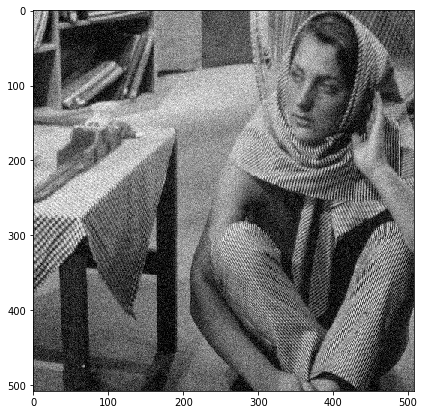

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
from scipy.signal import convolve2d
from math import *
import time
from google.colab import drive
%matplotlib inline

plt.rcParams['figure.figsize'] = [7, 7]

def load_image(filename):
    img = np.asarray(Image.open(filename))
    img = img.astype("float32") / 255.
    return img

def gray2rgb(image):
    return np.repeat(np.expand_dims(image, 2), 3, axis=2)

def show_image(img):
    if len(img.shape) == 2:
        img = gray2rgb(img)
    plt.imshow(img, interpolation='nearest')

# load the image
drive.mount('/content/gdrive')
im = load_image('/content/gdrive/My Drive/noisy_image.jpg')
im = im.mean(axis=2) # convert to grayscale
show_image(im)

Mean Filter using "for" loop
-----------

Let's try to remove this grain with a mean filter. For every pixel in the image, we want to take an average (mean) of the neighboring pictures. Implement this operation using "for" loops and visualize the result:

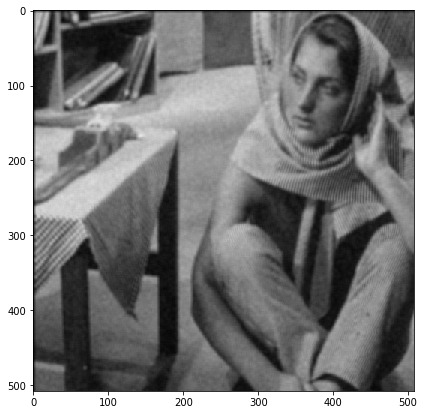

In [7]:
im_pad = np.pad(im, 5, mode='constant')  # pad the border of the original image
im_out = np.zeros_like(im)  # initialize the output image array

y,x = np.shape(im)

for row in range(y):
    for col in range(x):
        im_out[row,col] = np.sum(im_pad[1 + row: 6 + row, 1 + col: 6 + col])/25
show_image(im_out)


Implement the `convolve_image` function.
-----------

In practice, applying filters to images can be more efficient by using convolution, which is a function that takes as input the raw image and a filter matrix, and outputs the convolved image. Implement your `convolve_image` function below.

In [8]:
def convolve_image(image, filter_matrix):
    filter_matrix = np.flipud(np.fliplr(filter_matrix))  
    convolved_image = np.zeros_like(image)
    shape = np.shape(filter_matrix)
    surr_rows = int(shape[0]/2)
    surr_cols = int(shape[1]/2)
    im_mat_pad = np.pad(im, [(surr_rows, surr_rows),(surr_cols, surr_cols)], mode='constant')
    for row in range(np.shape(image)[0]):
        for col in range(np.shape(image)[1]):
            #convolved_image[row,col] = np.sum(im_mat_pad[row: shape[0] + row, col: shape[1] + col])/(shape[0] * shape[1])
            convolved_image[row,col] = (filter_matrix * im_mat_pad[row:row +shape[0], col:col+shape[1]]).sum()
    return convolved_image


Mean Filter with Convolution
----------------------------

In [9]:
mean_filt = np.full((5,5), 0.04)

Apply mean filter convolution using your `convolve_image` function and the `mean_filt` matrix.

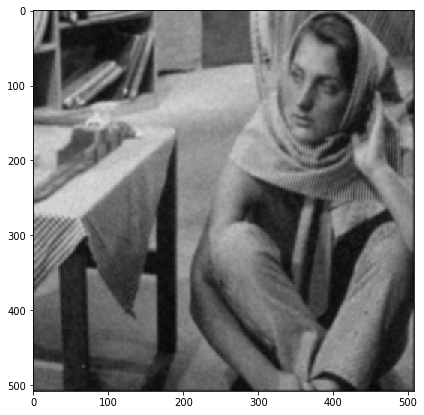

In [10]:
show_image(convolve_image(im, mean_filt))

Compare convolution result with the `scipy.signal.convolve2d` function (they should look the same).

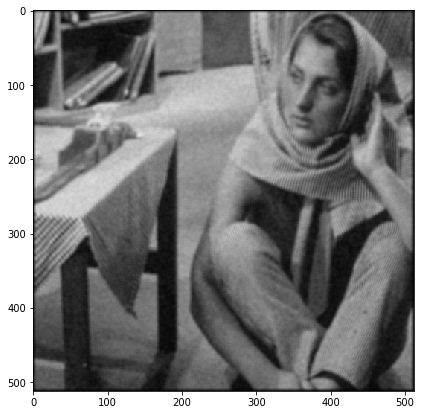

In [11]:
show_image(convolve2d(im, mean_filt))

Note: In the sections below, we will use the `scipy.signal.convolve2d` function for grading. But fill free to test your `convolve_image` function on other filters as well.

Gaussian Filter
---------------

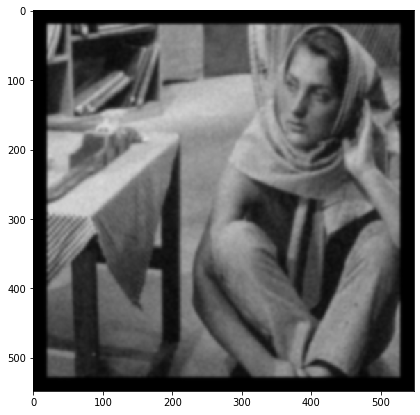

In [12]:
def gaussian_filter(sigma, k=20):
    size = 2*k
    denominator = (2*np.pi)**0.5 * sigma
    constant_term = (1/denominator)
    output_matrix = np.full((size + 1, size + 1),constant_term) 
    output_matrixy = np.full((size + 1,size + 1), constant_term)

    for x in range(-k, k + 1):
        output_matrix[:,x + k] = constant_term*np.e**-((x**2)/(2*sigma**2)) 

    for y in range(-k,k + 1):
        output_matrixy[y + k,:] = constant_term*np.e**-((y**2)/(2*sigma**2)) 

    output_matrix = np.multiply(output_matrix, output_matrixy)
    return output_matrix
show_image(convolve2d(im, gaussian_filter(2)))

The amount the image is blurred changes depending on the sigma parameter. Change the sigma parameter to see what happens. Try a few different values.

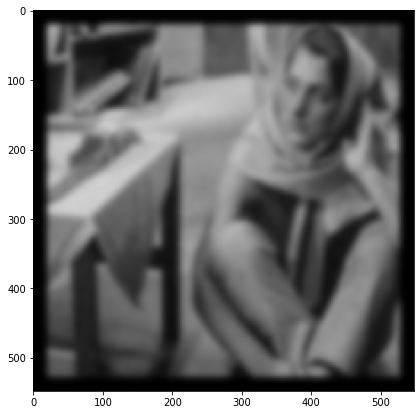

In [13]:
show_image(convolve2d(im, gaussian_filter(5)))

Edge Detection
=========================

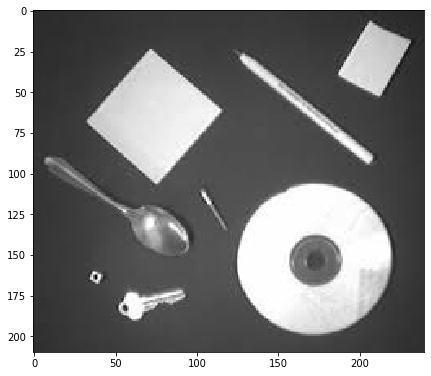

In [15]:
im = load_image('/content/gdrive/My Drive/edge_detection_image.jpg')
im = im.mean(axis=2) # convert to grayscale
show_image(im)

Delta (Gradient) Filters
-------------

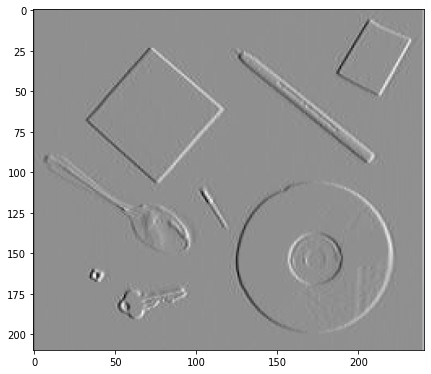

In [16]:
delta_filt = np.zeros((1,2))
delta_filt[0,0] = -1
delta_filt[0,1] = 1
plt.imshow(convolve2d(im, delta_filt), cmap='gray')

Noise
-----

The issue with the delta filter is that it is sensitive to noise in the image. Let's add some Gaussian noise to the image below, and visualize what happens. The edges should be hard to see.

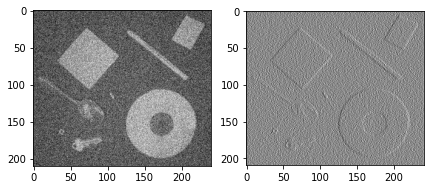

In [18]:
im = load_image('/content/gdrive/My Drive/edge_detection_image.jpg')
im = im.mean(axis=2)
im = im + 0.2*np.random.randn(*im.shape)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(im, cmap='gray')
axarr[1].imshow(convolve2d(im, delta_filt), cmap='gray')

Laplacian Filters
-----------------

Laplacian filters are edge detectors that are robust to noise 

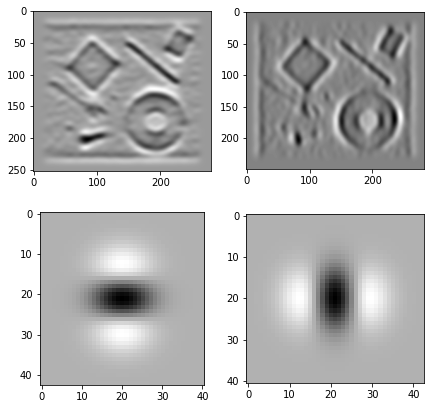

In [19]:
gauss_and_first = convolve2d(gaussian_filter(5), delta_filt)
lap_x_filt = convolve2d(gauss_and_first, delta_filt)

gauss_and_first_y = convolve2d(gaussian_filter(5), np.transpose(delta_filt))
lap_y_filt = convolve2d(gauss_and_first_y, np.transpose(delta_filt)) 

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(convolve2d(im, lap_y_filt), cmap='gray')
axarr[0,1].imshow(convolve2d(im, lap_x_filt), cmap='gray')
axarr[1,0].imshow(lap_y_filt, cmap='gray')
axarr[1,1].imshow(lap_x_filt, cmap='gray')



```
# This is formatted as code
```
Hybrid Images
========================

Hybrid images is a technique to combine two images in one. Depending on the distance you view the image, you will see a different image. This is done by merging the high-frequency components of one image with the low-frequency components of a second image. In this problem, you are going to use the Fourier transform to make these images. But first, let's visualize the two images we will merge together.

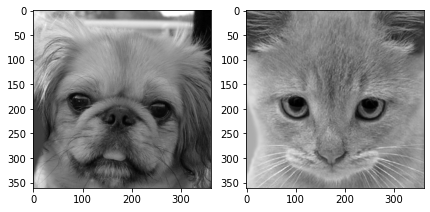

In [20]:
from numpy.fft import fft2, fftshift, ifftshift, ifft2

dog = load_image('/content/gdrive/My Drive/dog.jpg').mean(axis=-1)[:, 25:-24]
cat = load_image('/content/gdrive/My Drive/cat.jpg').mean(axis=-1)[:, 25:-24]

f, axarr = plt.subplots(1,2)
axarr[0].imshow(dog, cmap='gray')
axarr[1].imshow(cat, cmap='gray')

Fourier Transform
-----------------

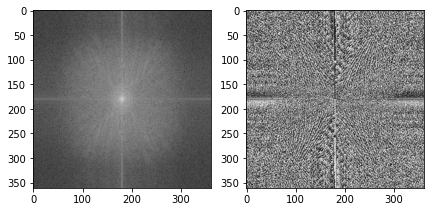

In [21]:
cat_fft = np.fft.fft2(cat)
cat_fft = np.fft.fftshift(cat_fft)
dog_fft = np.fft.fft2(dog)
dog_fft = np.fft.fftshift(dog_fft)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.log(np.abs(cat_fft)), cmap='gray')
axarr[1].imshow(np.angle(cat_fft), cmap='gray')

Low and High Pass Filters
-------------------------

By masking the Fourier transform, you can compute both low and high pass of the images. In Fourier space, below we create the mask for a high pass filter of the cat, and the mask for a low pass filter of the dog. Then, convert back to image space and visualize these images.

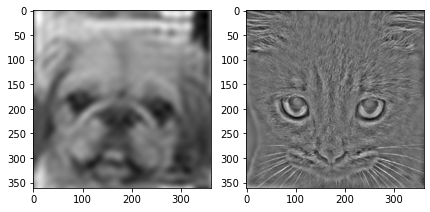

In [22]:
fft_shape = np.shape(cat)
high_mask = np.ones(fft_shape)

high_mask[fft_shape[0]//2 - 11:fft_shape[0]//2 + 11 ,fft_shape[1]//2 -11:fft_shape[1]//2 + 11] = 0
high_mask_fft = np.fft.fftshift(np.fft.fft2(high_mask))

low_mask = np.zeros(fft_shape)
low_mask[fft_shape[0]//2 - 15:fft_shape[0]//2 + 15 ,fft_shape[1]//2 -15:fft_shape[1]//2 + 15] = 1

low_mask_fft = np.fft.fftshift(np.fft.fft2(low_mask))
cat_fft = cat_fft * high_mask
dog_fft = dog_fft * low_mask

cat_filtered = np.real(np.fft.ifft2(ifftshift(cat_fft))) 
dog_filtered = np.real(np.fft.ifft2(ifftshift(dog_fft)))  

f, axarr = plt.subplots(1,2)
axarr[0].imshow(dog_filtered, cmap='gray')
axarr[1].imshow(cat_filtered, cmap='gray')

Hybrid Image Results
--------------------

Now that we have the high pass and low pass fitlered images, we can create a hybrid image by adding them. Depending on whether you are close or far away from your monitor, you should see either a cat or a dog.

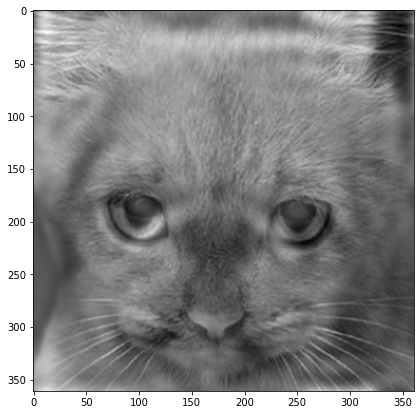

In [23]:
hybrid = dog_filtered + cat_filtered 

plt.imshow(hybrid, cmap='gray')

Acknowledgements
----------------

This experiment is based on assignments from Aude Oliva at MIT, and James Hays at Georgia Tech, and Carl Vondrick at Columbia University. 

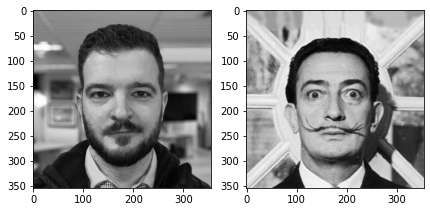

In [25]:
me = load_image('/content/gdrive/My Drive/hinman.jpg')
dali = load_image('/content/gdrive/My Drive/dali.jpg')

f, axarr = plt.subplots(1,2)
axarr[0].imshow(me, cmap='gray')
axarr[1].imshow(dali, cmap='gray')

# Fourier Transform
me_fft = np.fft.fft2(me)
me_fft = np.fft.fftshift(me_fft)
dali_fft = np.fft.fft2(dali) 
dali_fft = np.fft.fftshift(dali_fft)

fft_shape2 = np.shape(me)
high_mask2 = np.ones(fft_shape2)   #''' TODO: Create the mask for a high pass filter 

high_mask2[fft_shape2[0]//2 - 17:fft_shape2[0]//2 + 17 ,fft_shape2[1]//2 -17:fft_shape2[1]//2 + 17] = 0
high_mask_fft2 = np.fft.fftshift(np.fft.fft2(high_mask2))

low_mask2 = np.zeros(fft_shape2)   #''' TODO: Create the mask for a low pass filter 
low_mask2[fft_shape2[0]//2 - 17:fft_shape2[0]//2 + 17 ,fft_shape2[1]//2 -17:fft_shape2[1]//2 + 17] = 1

low_mask_fft2 = np.fft.fftshift(np.fft.fft2(low_mask2))
me_fft = me_fft * low_mask2
dali_fft = dali_fft * high_mask2



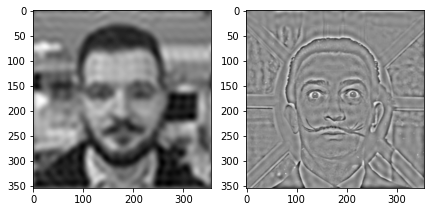

In [26]:
me_filtered = np.real(np.fft.ifft2(ifftshift(me_fft))) 
dali_filtered = np.real(np.fft.ifft2(ifftshift(dali_fft)))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(me_filtered, cmap='gray')
axarr[1].imshow(dali_filtered, cmap='gray')

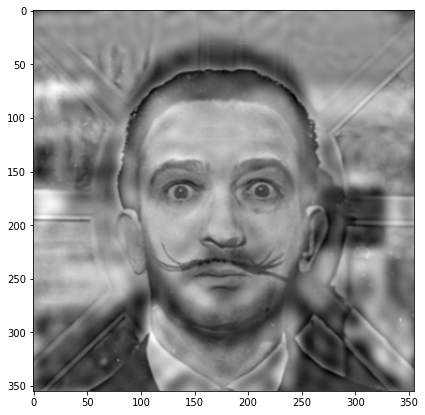

In [27]:
hybrid2 = me_filtered + dali_filtered #''' TODO: Compute the hybrid image here. '''

plt.imshow(hybrid2, cmap='gray')